In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import kneighbors_graph as kg
from sklearn.datasets import make_circles, make_moons, load_sample_image 
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import cg

import warnings
warnings.filterwarnings('ignore')

import functionality as fn

# Centers:

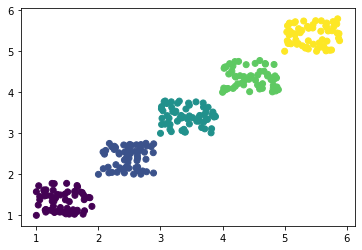

In [2]:
centers = np.array(
    [
        [1,1],
        [2,2],
        [3,3],
        [4,4],
        [5,5],
    ]
)

# Make and plot some points(5 clusters):
user_data, user_labels_data = fn.rand_around_centers(centers, number=60)
fn.draw2d(user_data, c=user_labels_data)

In [3]:
try:
    want = 1 # cluster label
    count = 3 # number of local clustering initializers
    nn_arr = [5, 10, 15, 20] # different nearest neighbours numbers 
    want_indices = np.argwhere(user_labels_data==want).squeeze()
    u = want_indices[np.random.randint(0, want_indices.size, size=count)]

    # Find local clusters for different NN numbers
    user_local = []
    for i in nn_arr:
        local = fn.process(
            user_data,
            nn=i,
            u=u,
            k=150,
            tol=0.0001,
            err=0.001,
            n_iter = 20000,
            shift=0.0001,
        )
        user_local.append(local)
    
    # Score the results:
    metric_results = []
    for i in range(4):
        metric_results.append(fn.metric(user_local[i], user_labels_data, want))

    # Print scores:
    print("Centers:\n")
    for i in range(4):
        print(f"NN = {nn_arr[i]} -> Score = {metric_results[i]}")    

except fn.Error as err:
    print(err.info)

Centers:

NN = 5 -> Score = 1.0
NN = 10 -> Score = 1.0
NN = 15 -> Score = 1.0
NN = 20 -> Score = 1.0


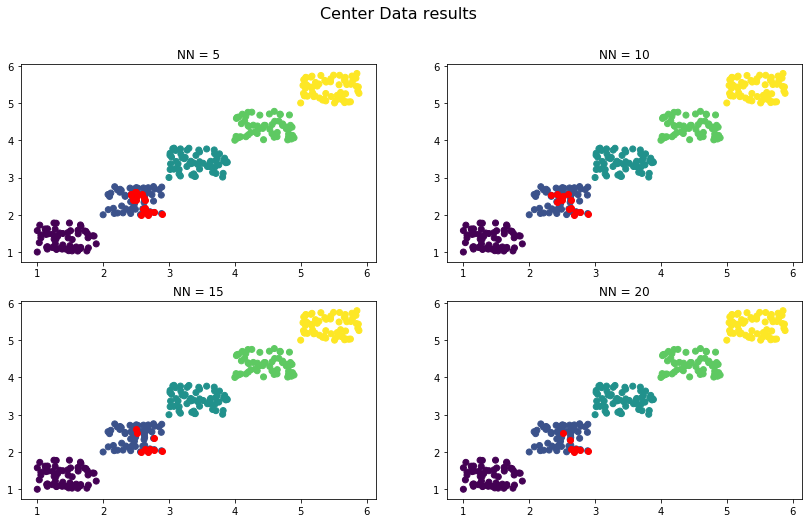

In [4]:
# Let`s get some graphs:
fn.plot_results(
    user_data,
    user_labels_data,
    user_local,
    name_global="Center Data results",
    names_local=["NN = 5", "NN = 10", "NN = 15", "NN = 20"],
)

# Circles:

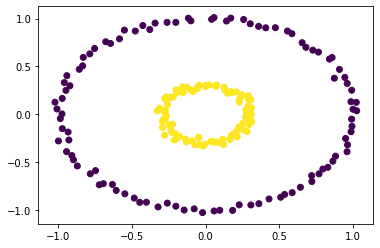

In [6]:
# Make and plot some points(2 clusters):
circles, labels_circles = make_circles(200, noise=0.02, factor=0.3)
fn.draw2d(circles, labels_circles)

In [7]:
try:
    want = 1 # cluster label
    count = 5 # number of local clustering initializers
    nn_arr = [5, 10, 15, 20] # different nearest neighbours numbers 
    want_indices = np.argwhere(labels_circles==want).squeeze()
    u = want_indices[np.random.randint(0, want_indices.size, size=count)]

    # Find local clusters for different NN numbers
    circles_local = []
    for i in nn_arr:
        local = fn.process(
            circles,
            nn=i,
            u=u,
            k=1000,
            tol=0.00001,
            err=0.01,
            n_iter = 100000,
            shift=0.00001,
        )
        circles_local.append(local)

    # Score the results:    
    metric_results = []
    for i in range(4):
        metric_results.append(fn.metric(circles_local[i], labels_circles, want)) 
    
    # Print scores:
    print("Circles:\n")
    for i in range(4):
        print(f"NN = {nn_arr[i]} -> Score = {metric_results[i]}") 

except fn.Error as err:
    print(err.info)        

Circles:

NN = 5 -> Score = 1.0
NN = 10 -> Score = 1.0
NN = 15 -> Score = 1.0
NN = 20 -> Score = 1.0


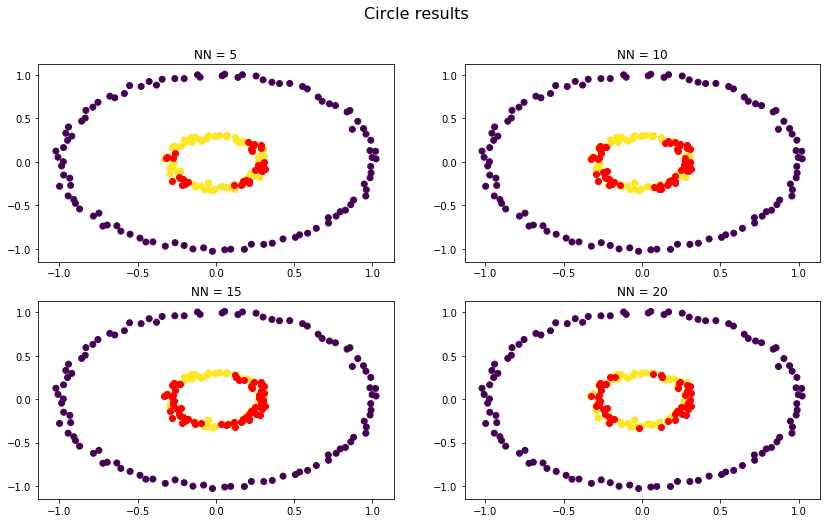

In [8]:
fn.plot_results(
    circles,
    labels_circles,
    circles_local,
    name_global="Circle results",
    names_local=["NN = 5", "NN = 10", "NN = 15", "NN = 20"],
)

# Digits:

In [9]:
# Load data:
data_dict = load_digits()
images = data_dict['images']
data = data_dict['data']
target = data_dict['target']
t_names = data_dict['target_names']

In [10]:
# This is small mnist:
data.shape

(1797, 64)

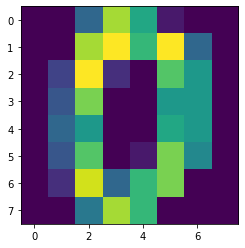

In [11]:
# What is the data???
plt.imshow(images[0])

In [12]:
try:
    want = 1 # cluster label
    count = 10 # number of local clustering initializers
    nn_arr = [5, 10, 15, 20] # different nearest neighbours numbers 
    want_indices = np.argwhere(target==want).squeeze()
    wc_ix = want_indices[np.random.randint(0, want_indices.size, size=count)]

    # Find local clusters for different NN numbers
    digit_local = []
    for i in nn_arr:
        local = fn.process(
            data,
            nn=i, 
            u=wc_ix,
            k=150,
            tol=0.0001,
            err=0.001,
            n_iter = 20000,
            shift=0.0001,
        )
        digit_local.append(local)

    # Score the results:    
    metric_results = []
    for i in range(4):
        metric_results.append(fn.metric(digit_local[i], target, want)) 
    
    # Print scores:
    print("Digits:\n")
    for i in range(4):
        print(f"NN = {nn_arr[i]} -> Score = {metric_results[i]}")

except Error as err:
    print(err.info)          

Digits:

NN = 5 -> Score = 0.9310344827586207
NN = 10 -> Score = 1.0
NN = 15 -> Score = 1.0
NN = 20 -> Score = 1.0


# Class and functions for Local Spectral Clustering method:
## Hint: all the functions are in the "functionality.py" file

In [ ]:
class Error(Exception):
    """Base class for exceptions in this module."""
    def __init__(self, info):
        self.info = info

In [ ]:
class LocalSpectral:
    """
        This class is used to solve Spectral clustering task 
        with constraints on localization.
        
        Parameters.
        ----------
        A : numpy.ndarray
            Adjacency matrix of graph nodes;
    """
    def __init__(self, A):
        self.A = A
        self.diag = A.sum(axis=1)
        self.vol_graph = self.diag.sum()
        self.laplacian = csr_matrix(np.diag(self.diag) - A)
        self.s = None    
   

    def _solve(self, s, k, tol, err, n_iter, shift):
        b = self.diag * s
        gamma = -self.vol_graph
        A = self.laplacian - gamma*diags(self.diag)
        y, _ = cg(A, b)
        check = (s.dot(self.diag * y))**2
        num_iter = 0
        while np.abs(check - k) > err:
            num_iter += 1
            gamma += shift * self.vol_graph
            A = self.laplacian - gamma*diags(self.diag)
            y, _ = cg(A, b, tol=tol)
            check = (s.dot(self.diag * y))**2
            if num_iter == n_iter:
                print("Ended iterations.")
                break
        self.x = y 
        self.gamma = gamma
    
    
    def _volume(self, s):
        return self.diag[s].sum()
    
    
    def _conductance(self, s):
        vol = self._volume(s)
        denom = vol * (self.vol_graph - vol)
        summ = 0
        for i in s:
            for j in range(self.A[i, :].size):
                if self.A[i, j] > 0.0:
                    if j not in s:
                        summ += 1
                    
        return (self.vol_graph * summ) / denom 
    
    
    def _sweep_cut(self, k):
        p_d = pd.Series(self.x).sort_values(ascending=False)
        supp_length = np.sum(self.x > 0.0)
        a = self.x.dot(self.laplacian.dot(self.x))
        b = self.x.dot(self.diag * self.x)
        phi = a / b
        s = []
        for j in range(1, supp_length + 1):
            s = list(p_d.iloc[list(range(0, j))].index)
            cond = self._conductance(s)
            cond_help = 1000
            if cond**2 <= 8*phi and cond < cond_help and self._volume(s) < k:
                cond_help = cond
                self.s = s
        
        if self.s == None:
            raise Error("\nFound empty cluster, change parameters\n")
        
    
    
    def process(self, u, k=15, tol=0.00001, err=0.001, n_iter = 10000, shift=0.001):
        """
            This method produce list of nodes that solve Spectral Graph Partitioning task.
        
            Parameters.
            ----------
            u : list
                List of initial local nodes;
            
            k : int
                Volume that we want our local set to have;
            
            tol : double
                Tolerance that is used to solve system of linear equations by
                Conjugate Gradients method;
                
            err : double
                We want to find 'x'- local partitioning vector s.t: abs((x^T*D*s)^2 - k) < err
            
            n_iter : int
                Number of iterations we allow to find 'x' - local partitioning vector.
            
            shift : double
                Shift that we use to approximate 'x'.
        
            Returns.
            ----------
            out : list
                List of nodes according initial data that fit objective;
                
        """
        s = np.zeros(self.A.shape[0])
        s[u] = 1.0
        self._solve(s, k=1/k, tol=tol, err=err, n_iter=n_iter, shift=shift)
        self._sweep_cut(k)
        return self.s

In [ ]:
# Produce random points around centers:
def rand_around_centers(centers, number=50):
    """
        Produce random points around centers.
        
        Parameters.
        ----------
        centers : numpy.ndarray
            This array includes x, y coordinates of centers;
        
        number : int
            What number of points do you want scattered around centers;
        
        Returns.
        ----------
        out : numpy.ndarray, numpy.ndarray
            The first array is filled with x, y coordinates of a point;
            The second array is filled with labels tailored to a point;    
    """
    result = []
    labels = []
    for c, j in zip(centers, range(centers.shape[0])):
        result.append(c)
        labels.append(j)
        for i in range(number):
            result.append(
                [c[0] + 0.9*np.random.rand(), c[1] + 0.8*np.random.rand()]
            )
            labels.append(j)
    return np.array(result), np.array(labels)       


# Draw data like scatter plot, plus local coloring
def draw2d(data, c=None, s=None):
    """
        Plot scatter data.
        
        Parameters.
        ----------
        data : numpy.ndarray
            This array includes x, y coordinates of data points;
        
        c : array_like
            Labels array to emphasize color of points;
        
        s : array_like
            Local clustering points, their position in data;
            If s=None then function does not plot extra color points;
            Else highlights them with red color.
    """
    plt.scatter(data[:, 0], data[:, 1], c=c)
    if s != None:
        plt.scatter(data[s][:, 0], data[s][:, 1], c='red')

In [ ]:
def plot_results(data, labels, local_labels, name_global, names_local):
    """
        It is just convenient function to plot the results.
        
        Parameters.
        ----------
        data : numpy.ndarray
            Array that contains x, y coordinates of points;
            
        labels : numpy.ndarray
            Array that contains labels for all the points in "data";
        
        local_labels : numpy.ndarray
            Array that contains such row values of points
            that lie in a local cluster;
            
        name_global : string
            Name used for a plot in the whole;
        
        names_local : list of strings
            Names used locally in plots;
        
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'{name_global}', fontsize=16)

    
    for i in range(4):
        m = i // 2
        n = i % 2
        axs[m, n].set_title(f'{names_local[i]}')
        axs[m, n].scatter(data[:, 0], data[:, 1], c=labels)
        axs[m, n].scatter(data[local_labels[i]][:, 0], data[local_labels[i]][:, 1], c='red')

In [ ]:
def metric(local, target, label):
    """
        This metric counts ratio between true label number of points in local set
        and all the points in the local cluster.
       
        Parameters.
        ----------
        local : list
            List of points in a local cluster, its row numbers;
        
        target : numpy.ndarray
            Array that contains labels of all the points in initial data;
        
        label : int
            Label we used for initial points;
               
        Returns.
        ----------
        out : double
            
            
    """
    result = target[local]
    return (result==label).sum() / result.size

In [ ]:
def process(data, nn, u, k, tol, err, n_iter, shift):
    """
        Extra wrapper to use this program more properly.
        
        Parameters.
        ----------
        data : numpy.ndarray
            Array representing data points, x and coordinates;
        
        nn : int
            The number of nearest neighbours to make Adjacency matrix; 
            
        u : list
            List of initial local nodes;
            
        k : int
            Volume that we want our local set to have;
            
        tol : double
            Tolerance that is used to solve system of linear equations by
            Conjugate Gradients method;
                
        err : double
            We want to find 'x'- local partitioning vector s.t: abs((x^T*D*s)^2 - k) < err
            
        n_iter : int
            Number of iterations we allow to find 'x' - local partitioning vector.
            
        shift : double
            Shift that we use to approximate 'x'.
        
        Returns.
        ----------
        out : list
            List of nodes according initial data that fit objective;
        
    """
    A = kg(data, nn).toarray()
    if (A - A.T).sum() != 0:
        raise Error("\nNon-symmetric matrix\n")
    
    model = LocalSpectral(A)
    s = model.process(u=u, k=k, tol=tol, err=err, n_iter=n_iter, shift=shift)
    return s